# Lightning Localization using Multilateration and Non-Linear Optimization

In this demo, we will explore how to pinpoint the exact location of a lightning strike given a set of lightning sensors and their measurements. The solution will use a multilateration algorithm to find the location of the strike based on the reported distance of the sensors. Since the measured distance may be noisy or not exact, we will use a non-linear optimization algorithm to find the best location for the strike given the measurements.

Let's import some libraries that we need.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rich.pretty import pprint as pp

from scipy.optimize import minimize

np.random.seed(42)
plt.style.use('default')

Lets setup a sensor network with 4 sensors and a lightning strike:

$$
\text{station}_i = (\text{x}, \text{y})\\
\text{station}_0 = (1,1)\\
\text{station}_1 = (9,1)\\
\text{station}_2 = (6,7)\\
\text{station}_3 = (1,9)\\
\\
\text{strike} = (\text{x}, \text{y}) = (5.2, 3.1)
$$

Then we can compute the distance between the strike and each sensor:

$$
d_i = \sqrt{\left(\text{station}_{i,x} - \text{strike}_x\right)^2 + \left(\text{station}_{i,y} - \text{strike}_y\right)^2}
$$

We can also add some noise to the measurements to simulate these measurements in reality using a normal distribution:

$$
d_{i,\text{noisy}} = d_i + \mathcal{N}(\mu=0,\sigma=1)
$$

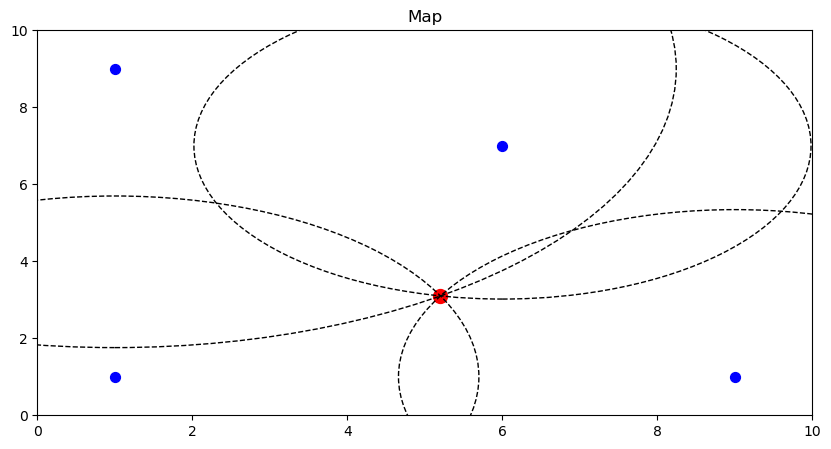

In [3]:
strike_location = np.array([5.2, 3.1])

sensor_locations = np.array([[1,1],
                             [9,1],
                             [6,7],
                             [1,9]])

# compute the distances between the strike location and each sensor
true_sensor_distances = np.linalg.norm(sensor_locations - strike_location, axis=1)
noisy_sensor_distances = true_sensor_distances + np.random.normal(0, 1, size=sensor_locations.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sensor_locations[:, 0], sensor_locations[:, 1], marker='o', color='b', s=50)

# draw circle indicating distance of each sensor from the strike location
for i in range(sensor_locations.shape[0]):
    circle = plt.Circle(sensor_locations[i], true_sensor_distances[i], color='k', fill=False, linestyle='--')
    ax.add_artist(circle)

ax.scatter(strike_location[0], strike_location[1], marker='o', color='r', s=100)


ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_title('Map')
plt.show()

Only given the sensor locations and the measured distances, we want to compute the location of the lightning strike. We can use the multilateration algorithm to find the location of the strike.

Looking at one measurement, we know the correct strike location has to be on the circle with a radius equal to the measured distance from the sensor.

Given any predicted location, we can compute the difference between the predicted location to the station and the measured distance. This gives us an error map we can plot for all possible locations on the map. The lowest value should be on the circle of possible strike locations, with the value increasing as we move away from the circle.

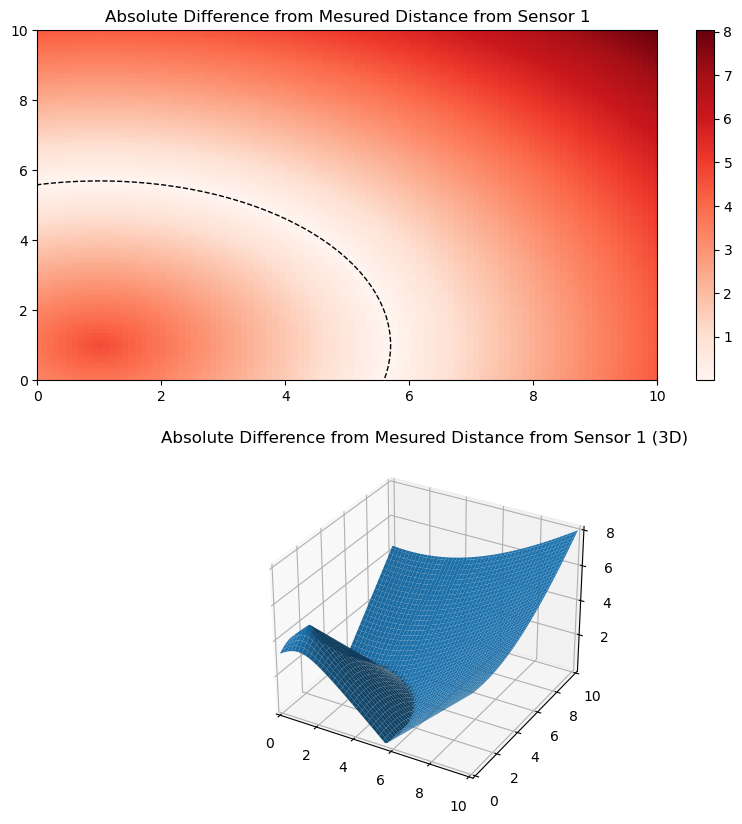

In [18]:
# meshgrid
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)

sensor = sensor_locations[0]
distance = true_sensor_distances[0]

Z = np.abs(np.sqrt((X - sensor[0])**2 + (Y - sensor[1])**2) - distance)
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.pcolormesh(X, Y, Z, cmap='Reds', shading='auto')
plt.gca().add_artist(plt.Circle(sensor, distance, color='k', fill=False, linestyle='--'))
plt.colorbar()
plt.title('Absolute Difference from Mesured Distance from Sensor 1')
plt.xlim([0, 10])
plt.ylim([0, 10])

# plt.subplot(2, 1, 2 )
# plt.pcolormesh(X, Y, np.log(Z), cmap='Reds', shading='auto')
# plt.colorbar()
# plt.title('Absolute Difference from Mesured Distance from Sensor 1 (Log Scaled)')
# plt.xlim([0, 10])
# plt.ylim([0, 10])
# 3d plot
plt.subplot(2, 1, 2, projection='3d')
plt.gca().plot_surface(X, Y, Z, edgecolor='none')
plt.gca().add_artist(plt.Circle(sensor, distance, color='k', fill=False, linestyle='--'))
plt.title('Absolute Difference from Mesured Distance from Sensor 1 (3D)')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.show()


# plt.tight_layout()
plt.show()


This error map can be computed for all stations and associated measurements and added together to build a global error map.

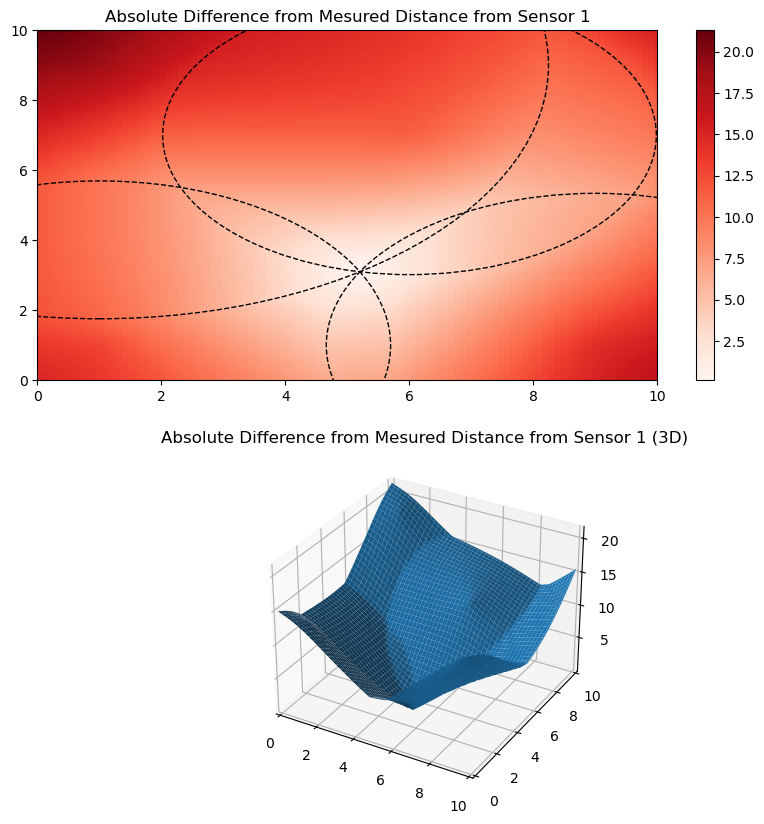

In [19]:
# meshgrid
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)
for i in range(sensor_locations.shape[0]):
    sensor = sensor_locations[i]
    distance = true_sensor_distances[i]
    Z += np.abs(np.sqrt((X - sensor[0])**2 + (Y - sensor[1])**2) - distance)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.pcolormesh(X, Y, Z, cmap='Reds', shading='auto')
for i in range(sensor_locations.shape[0]):
    sensor = sensor_locations[i]
    distance = true_sensor_distances[i]
    plt.gca().add_artist(plt.Circle(sensor, distance, color='k', fill=False, linestyle='--'))
plt.colorbar()
plt.title('Absolute Difference from Mesured Distance from Sensor 1')
plt.xlim([0, 10])
plt.ylim([0, 10])
# plot in 3d
plt.subplot(2, 1, 2, projection='3d')
plt.gca().plot_surface(X, Y, Z, edgecolor='none')
for i in range(sensor_locations.shape[0]):
    sensor = sensor_locations[i]
    distance = true_sensor_distances[i]
    plt.gca().add_artist(plt.Circle(sensor, distance, color='k', fill=False, linestyle='--'))
plt.title('Absolute Difference from Mesured Distance from Sensor 1 (3D)')
plt.xlim([0, 10])
plt.ylim([0, 10])

plt.show()


Now all we need to do is find the best location for the strike given the measurements. From the plots, it is clear where the minimum point is, but we need to find this programmatically.

To do this, we can formulate the problem as an optimization problem and use scipy to solve it.

$$
\min_{(\text{strike}_x, \text{strike}_y) \in \mathbb{R}} \sum_{i=0}^{3} \left| d_{i,\text{noisy}} - \sqrt{\left(\text{strike}_x - \text{station}_{i,x}\right)^2 + \left(\text{strike}_y - \text{station}_{i,y}\right)^2} \right|
$$

We can start with an initial guess of the strike location of $(0, 0)$ and use the Nelder-Mead optimization algorithm to minimize the function.

In [29]:
def obj(x, sensor_locations, sensor_measurements):
    errors = np.abs(np.sqrt((x[0] - sensor_locations[:, 0])**2 +
                    (x[1] - sensor_locations[:, 1])**2) - sensor_measurements)
    return np.sum(errors)

track_x = []

def callable_progress(x):
    track_x.append(x)


sol = minimize(obj, np.array([0, 0]), args=(sensor_locations, true_sensor_distances),
               method='Nelder-Mead', callback=callable_progress)
pp(sol)

print(f"Final Solution: {sol.x}")
print(f"Number of Iterations: {sol.nit}")

track_x = np.array(track_x)

mae = np.mean(np.abs(sol.x - strike_location))
print(f'Predicted Location MAE: {mae}')

 final_simplex: (array([[5.20002943, 3.10001197],
│      [5.20000483, 3.09996883],
│      [5.19994381, 3.10002059]]), array([7.65925203e-05, 8.66891437e-05, 1.58441187e-04]))
│   │      fun: 7.659252028258123e-05
│      message: 'Optimization terminated successfully.'
│   │     nfev: 160
│   │      nit: 82
│   │   status: 0
│      success: True
│   │   │    x: array([5.20002943, 3.10001197])

Final Solution: [5.20002943 3.10001197]
Number of Iterations: 82
Predicted Location MAE: 2.0700643232673954e-05


We can also print the progress of the optimizer through its iterations and see how it converges.

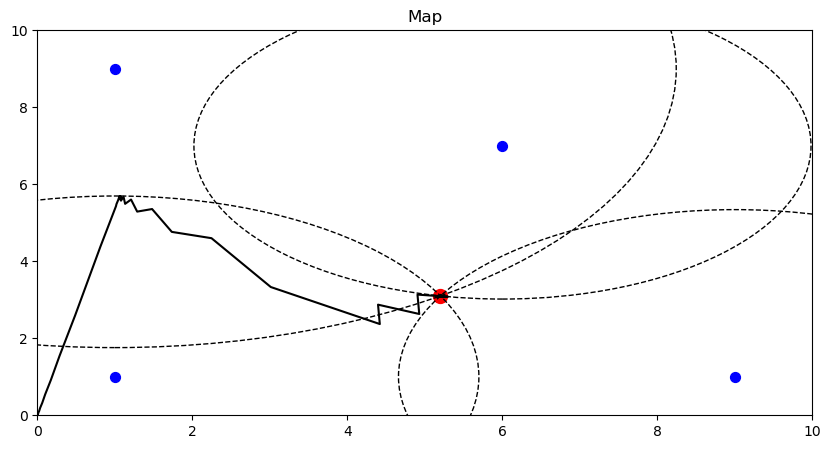

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sensor_locations[:, 0], sensor_locations[:, 1], marker='o', color='b', s=50)

# draw circle indicating distance of each sensor from the strike location
for i in range(sensor_locations.shape[0]):
    circle = plt.Circle(sensor_locations[i], true_sensor_distances[i], color='k', fill=False, linestyle='--')
    ax.add_artist(circle)

ax.scatter(strike_location[0], strike_location[1], marker='o', color='r', s=100)
ax.plot(track_x[:, 0], track_x[:, 1], color='k')


ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_title('Map')
plt.show()